# Check dataflow:
- training

In [1]:
import os
from pathlib import Path
import sys

import numpy as np
import pandas as pd

sys.path.insert(0, (Path(".").resolve().parent / "Detectron.pytorch" / "lib").as_posix())

In [2]:
pwd=!cd ../ && echo ${PWD}/
pwd = Path(pwd[0])
data_dir = (pwd / "input" / "as_mscoco")

os.environ['DATA_DIR'] = data_dir.as_posix()
os.environ['CUSTOM_DATASETS'] = (pwd / "datasets" / "dataset_catalog.py").as_posix()
base_output_path = Path("/home/storage_ntfs_1tb")
assert base_output_path.exists()

In [3]:
from core.config import cfg, cfg_from_file, assert_and_infer_cfg

cfg_from_file("../experiments/configs/train/train_faster_rcnn_X-101-64x4d-FPN_2x_gpu_1.yaml")
# cfg.DEBUG = True
cfg.TRAIN.IMS_PER_BATCH = 1
assert_and_infer_cfg()


In [4]:
from datasets.roidb import combined_roidb_for_training

In [5]:
roidb, ratio_list, ratio_index = combined_roidb_for_training(("open_images_v4_train", ), ())

loading annotations into memory...
Done (t=17.03s)
creating index...
index created!


In [6]:
from roi_data.loader import RoiDataLoader, MinibatchSampler, BatchSampler, collate_minibatch

In [7]:
roidb_size = len(roidb)
original_batch_size = cfg.NUM_GPUS * cfg.TRAIN.IMS_PER_BATCH
train_size = roidb_size // original_batch_size * original_batch_size

In [8]:
import torch 

batchSampler = BatchSampler(
    sampler=MinibatchSampler(ratio_list, ratio_index),
    batch_size=original_batch_size,
    drop_last=True
)

dataset = RoiDataLoader(
    roidb,
    cfg.MODEL.NUM_CLASSES,
    training=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_sampler=batchSampler,
    num_workers=cfg.DATA_LOADER.NUM_THREADS,
    collate_fn=collate_minibatch)


In [ ]:
import tqdm
from modeling.model_builder import Generalized_RCNN
import nn as mynn


maskRCNN = Generalized_RCNN()
maskRCNN.cuda()
maskRCNN = mynn.DataParallel(maskRCNN, cpu_keywords=['im_info', 'roidb'],
                             minibatch=True)

maskRCNN.train()


try:
    for input_data in tqdm.tqdm(dataloader):
        net_outputs = maskRCNN(**input_data)    
except KeyboardInterrupt:
    pass

  0%|          | 0/948332 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 504/948332 [02:02<63:46:40,  4.13it/s]

could not broadcast input array from shape (4) into shape (0)
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
Type 'copyright', 'credits' or 'license' for more information
IPython 6.3.1 -- An enhanced Interactive Python. Type '?' for help.

IPython	 bbox_inside_weights	 bbox_target_data	 bbox_targets	 cls	 clss	 e	 end	 ind	 
inds	 num_bbox_reg_classes	 start	 

Out[2]: 2404

Out[3]: (4,)

Out[4]: (512, 2404)

Out[5]: (0,)

Out[6]: 601

Out[7]: (512,)

Out[8]: 91

Out[9]: 
array([503., 177., 298., 298., 434., 503., 503., 298., 292., 434., 221.,
       308., 434., 221., 221., 540., 292., 221., 292., 434., 298., 177.,
       292., 503., 221., 177., 298., 434., 503., 236., 221., 434., 221.,
       540., 221., 568., 235., 601., 434., 503., 308., 434., 601., 540.,
       540., 308., 221., 298., 502., 298., 601., 502., 434., 298., 221.,
       236., 540., 502., 434., 298., 503., 502., 308., 502., 434., 601.,
       236., 434., 540., 540., 298., 177., 298., 502., 308., 236., 601.,
       177.,

In [ ]:
input_data.keys()

In [15]:
input_data['im_info']

[tensor([[ 800.0000, 1203.0000,    1.1747]])]

In [16]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

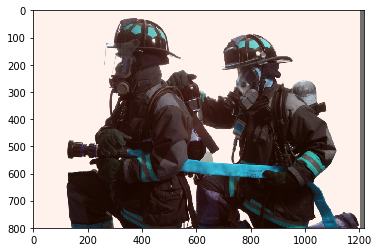

In [26]:
im = input_data['data'][0].detach().numpy()[0, ...].transpose((1, 2, 0))
im = ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)

plt.imshow(im)

In [29]:
import utils.blob as blob_utils

_roidb = list(map(lambda x: blob_utils.deserialize(x)[0], input_data['roidb'][0]))

In [30]:
_roidb

[{'box_to_gt_ind_map': array([0, 1, 2, 3], dtype=int32),
  'boxes': array([[ 143.,   45.,  547.,  664.],
         [ 221.,   29.,  449.,  213.],
         [ 422.,   72., 1023.,  678.],
         [ 594.,   73.,  815.,  285.]], dtype=float32),
  'gt_classes': array([ 69, 601,  69, 601], dtype=int32),
  'gt_overlaps': <4x602 sparse matrix of type '<class 'numpy.float32'>'
  	with 4 stored elements in Compressed Sparse Row format>,
  'has_visible_keypoints': False,
  'is_crowd': array([False, False, False, False]),
  'seg_areas': array([251100.,  42365., 365414.,  47286.], dtype=float32),
  'segms': [[], [], [], []]}]

In [38]:
im_scales = input_data['im_info'][0]
im_scales

tensor([[ 800.0000, 1203.0000,    1.1747]])

In [46]:
conv_body = maskRCNN.module.Conv_Body.to('cpu')

In [52]:
rpn = maskRCNN.module.RPN.to('cpu')

In [ ]:
inputs = conv_body(input_data['data'][0])

In [55]:
im_info = im_scales

In [60]:
try:
    res = rpn(inputs, im_info, _roidb)
except ValueError as e:
    print(e)
    import IPython
    IPython.embed()  # noqa

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


could not broadcast input array from shape (4) into shape (0)
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
Type 'copyright', 'credits' or 'license' for more information
IPython 6.3.1 -- An enhanced Interactive Python. Type '?' for help.

BatchSampler	 Generalized_RCNN	 IPython	 MinibatchSampler	 Path	 RoiDataLoader	 assert_and_infer_cfg	 base_output_path	 batchSampler	 
blob_utils	 cfg	 cfg_from_file	 collate_minibatch	 collect	 combined_roidb_for_training	 conv_body	 data_dir	 dataloader	 
dataset	 e	 entry	 get_fast_rcnn_blob_names	 im	 im_i	 im_info	 im_scales	 input_data	 
inputs	 maskRCNN	 mynn	 net_outputs	 np	 original_batch_size	 os	 pd	 plt	 
pwd	 ratio_index	 ratio_list	 roidb	 roidb_size	 rpn	 sns	 sys	 torch	 
tqdm	 train_size	 




In [54]:
# from datasets import json_dataset


# json_dataset.add_proposals(_roidb, rois, im_scales, crowd_thresh=0)

In [53]:
# from roi_data.fast_rcnn import get_fast_rcnn_blob_names, _sample_rois

# for im_i, entry in enumerate(_roidb):
#     frcn_blobs = _sample_rois(entry, im_scales[im_i], im_i)


In [21]:
from roi_data.minibatch import get_minibatch

In [17]:
batch_sampler_iter = iter(batchSampler)

In [19]:
for batch_index_tuple in batch_sampler_iter:
    for index_tuple in batch_index_tuple:
        # x = dataset[index_tuple]

        index, ratio = index_tuple
        single_db = [dataset._roidb[index]]
        blobs, valid = get_minibatch(single_db)

        break
    break

In [8]:
from roi_data.fast_rcnn import get_fast_rcnn_blob_names, _sample_rois

In [10]:
output_blob_names = get_fast_rcnn_blob_names()
blobs = {k: [] for k in output_blob_names}
blobs

{'bbox_inside_weights': [],
 'bbox_outside_weights': [],
 'bbox_targets': [],
 'labels_int32': [],
 'rois': []}

In [22]:
entry = roidb[0]
entry['bbox_targets']

array([[ 69.,   0.,   0.,   0.,   0.],
       [ 69.,   0.,   0.,   0.,   0.],
       [ 69.,   0.,   0.,   0.,   0.],
       [ 69.,   0.,   0.,   0.,   0.],
       [ 69.,   0.,   0.,   0.,   0.],
       [ 69.,   0.,   0.,   0.,   0.],
       [ 69.,   0.,   0.,   0.,   0.],
       [149.,   0.,   0.,   0.,   0.],
       [281.,   0.,   0.,   0.,   0.],
       [281.,   0.,   0.,   0.,   0.],
       [281.,   0.,   0.,   0.,   0.],
       [520.,   0.,   0.,   0.,   0.],
       [558.,   0.,   0.,   0.,   0.]], dtype=float32)

In [ ]:
for im_i, entry in enumerate(roidb):
    frcn_blobs = _sample_rois(entry, im_scales[im_i], im_i)

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline